# Motivation

Leskovec et al., in their book *Mining of massive datasets* (http://www.mmds.org/) wrote "In practice, for the Web itself, 50–75 iterations are sufficient to converge to within the error limits of double-precision arithmetic."

In 2008, [Google said that it was indexing 1 trillion pages](https://googleblog.blogspot.com/2008/07/we-knew-web-was-big.html). and according to [this site](https://venturebeat.com/2013/03/01/how-google-searches-30-trillion-web-pages-100-billion-times-a-month/#:~:text=Google%20says%20that%20it%20stores,now%20at%20100%20million%20gigabytes.), the number of pages is now 30 trillion. Let's calculate the amount of memory needed to store the vector $\textbf{v}$ for the 2008 reported value of Google of 1 trillion pages.

In [1]:
n = 1*(10**12)      # 1 trillion pages
bytes_per_float = 8      
bytes_per_gig = 10**9
n * bytes_per_float / bytes_per_gig

8000.0

This is 8 terrabyte for a 2008 data! Even if this value is dated, the vector $\textbf{v}$ is so large that it can't fit in memory; we can just imagine how large $M$ woul be. For this problem, performing MapReduce would definitely be beneficial. In fact, Google's original purpose for MapReduce is to calculate the matrix-vector multiplications needed in PageRank.

We present below two issues:

1. The matrix $M$, is, in fact, very sparse. We can save a lot of space by storing only the nonzero elements.
2. For some reason, we may opt to not use MapReduce, or, we wish to reduce the amount of data passed from Map tasks to Reduce tasks. 

Let's discuss the solutions to these two issues.

# Sparse Transition Matrices

Let us consider Graph 1 again. 

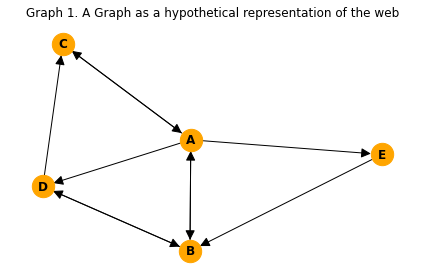

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G1 = nx.DiGraph()
G1.add_nodes_from(["A","B","C","D","E"])
G1.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), ("A","E"), 
    ("B","A"), ("B","D"), 
    ("C","A"),    
    ("D","B"), ("D","C"),
    ("E","B"),
])


plt.figure()  
plt.title("Graph 1. A Graph as a hypothetical representation of the web")
nx.draw(G1, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

We can save on space by only representing the nonzero entries in the Transition Matrix. 

|Source|(Destination, Value)|
|:--:|:--|
|A| (B, 1/4), (C, 1/4), (D, 1/4), (E, 1/4)|
|B| (A, 1/2), (D, 1/2)|
|C| (A, 1)|
|D| (B, 1/2), (C, 1/2)|
|E| (B, 1)|

However, we can actually go even further, by only representing the number of out-degrees from a node, and noting the other nodes to which it links. This works since we know that the probability of transitioning from one node to a node it connects to is the same (which is $1/\text{out-degree}$). Working this way, allows us to use integers instead of floats for our representation of the Transition Matrix. 

|Source|Degree|Destination|
|:--:|:--:|:--|
|A|4|B, C, D, E|
|B|2|A, D|
|C|1|A|
|D|2|B, C|
|E|2|B|

# Map Reduce when  *v* fits in memory

First, let's consider the naive case when $\textbf{v}$ fits in the memory.

Recall the update rule $\textbf{v}^{(t+1)}= \beta M\textbf{v}^{(t)} + (1-\beta)\textbf{e}/n$. 

For simpler notation, let us render this as 
$
\textbf{v'}= \beta M\textbf{v} + (1-\beta)\textbf{e}/n
$


Recall that $\beta$ is a constant and $\textbf{e}$ is just a vector of 1's. Thus, the update rule above is equivalent to 
- Performing a matrix-vector multiplication ($M\textbf{v}$)
- Multiplying the result by a constant ($\beta$)
- Adding to the result another constant ($(1-\beta)/n$)


Thus, the focus of the MapReduce functions will be on the matrix-vector multiplication, and it can be described as follows:

**Map function**: Produce key-value pair $(i, m_{ij}v_j)$ <br>
**Reduce function**: Sum all values associated with a given key $i$, resulting in the pair $(i, x_i)$

**Pyspark Illustration**

Please refer to the subsection [PageRank_Using_MapReduce](PageRank_Using_MapReduce.ipynb) for a discussion on the implementation of this procedure in pyspark. 

#  Striping Approach

As seen in the previous discussion, for Google's PageRank, $\textbf{v}$ does not actually fit in memory. A solution to address this is **striping**.
Here we divide the matrix $M$ into vertical stripes of equal length and similarly divide $\textbf{v}$ into horizontal stripes of equivalent height as shown in Figure 5 below. The goal is to choose a stripe length small enough so that $\textbf{v}$ could fit conveniently into the memory of one compute node.

<img src='images//Striping.PNG' width='350px'></img>
<center><b>Figure 1. Division of matrix and vector into 5 stripes</b></center>

The MapReduce changes in the following way: Each Map task is assigned a chunk from one of the
stripes of the matrix and gets the entire corresponding stripe of the vector. The Map and Reduce functions act exactly as previously described.

# Blocking Approach

The striping method described above has the following issues:
1. A vertical stripe of $M$ multiplied by a horizontal stripe of $\textbf{v}$ actually produces a vector of the same size as $\textbf{v}$. A problem happens this vector does not actually fit in memory.
2. If we want to aggregate sums at the Map tasks before sending to the Reducer, the striping method will not be efficient since the product of the matrix and vector stripes affect all rows of the resulting vector $\textbf{v'}$

To circumvent this limitation is partition $M$ into $k x k$ blocks while the vector $\textbf{v}$ is partitioned into $k$ stripes as shownin Figure 6 below. 

<img src='images/Blocking.PNG' width='450px'></img>
<center><b>Figure 2. Blocking approach</b></center>
<center><small>Image adapted from Leskovec, Rajaraman, and Ullman. Mining of Massive Datasets, 2019.</small></center>

The MapReduce can be implemented thus:
- There are $k^2$ Map tasks
- Each Map task gets one square, say $M_{ij}$, and one stripe of the vector, say $\textbf{v}_j$
- For each Map task, add the terms with common keys before sending to the Reducer 

**Advantage of this approach**
- As we process $M_{ij}$, we can keep both $\textbf{v'}_i$ and $\textbf{v}_j$ in memory 
    - Note that all terms generated from $M_{ij}$ and $\textbf{v'}_j$ contribute only to $\textbf{v'}_i$ and no other stripe of $\textbf{v}$

**EXERCISES**

1. Assuming that Google is indexing 30 trillion pages in 2021, how large of a memory is needed to load all the nodes' PageRanks in one vector?
2. Create a sparse representation of Graph 2 in the previous section.
3. Create a sparse representation of Graph 3 in the previous section.

**REFERENCE**

* Jure Leskovec, Anand Rajaraman, and Jeffrey D Ullman. Mining of massive datasets, chapter 5. Cambridge University Press, 3rd edition, 2019. http://www.mmds.org/. All figures, except Figure 2, were cropped from this book. Figure 2 was adapted from the presentation slides made available by the authors of the same book.